In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
# G = c = 1

In [4]:
# Working in manual cgs units here. 
def _dPdr(r, P, M, e):
    factor = -G/(c**2) 
    term1 = (e+P) 
    term2 = (M+4*np.pi*(r**3)*P/(c**2))
    term3 = r * (r-2*G*M/(c**2))
    return factor * (term1 * term2)/term3
    
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))


def coupledTOV(r, VEC, f_e_smooth):
    P, M = VEC
    e = f_e_smooth(P)   
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    return [dPdr, dMdr]

In [5]:
def df_to_ep(df):
    n_den = 2.3e14
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*(c**2)
    pressure = p*(c**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value="extrapolate")
    return f_e_smooth

In [6]:
def tov(ep, init_VEC, r_i, p_min, progress = False):
    func = ep

    r = ode(lambda r, VEC: coupledTOV(r, VEC, func)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 30 * km2cm
    # max_iter = 1000000 # Change back to this if "Excess work done on this call" error. 
    max_iter = 10000

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] > p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)

        results.append(integral)
        r_list.append(r.t+dr_init)

    #     dr_compute = r * dP /P 

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
    
    if progress:
        pbar.close()
    
    results = np.array(results, dtype = float)
    p, m = results.T
    r = np.array(r_list)
    return p, m, r

In [7]:
# Load EOS
df = pd.read_csv("sly230a.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1e-8
p_c = p[-8]
e_c = EOS(p_c)
m0 = e_c * 4/3 * np.pi * r_i**3
init_VEC = [p_c, m0]
msun = 2e33
p_min = min(p)

# Integrate
p, m, r_arr = tov(EOS, init_VEC, r_i, p_min, progress = True)
r_arr = r_arr/km2cm
m = m/msun

mStar = m.max()
mR = r_arr.max()
print(f"Star has mass {mStar:.1f} Msun and radius {mR:.1f}km")

 33%|███▎      | 3289/10000 [00:00<00:00, 32835.23it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
 34%|███▍      | 3398/10000 [00:00<00:00, 11545.41it/s]

Star has mass 2.1 Msun and radius 10.2km


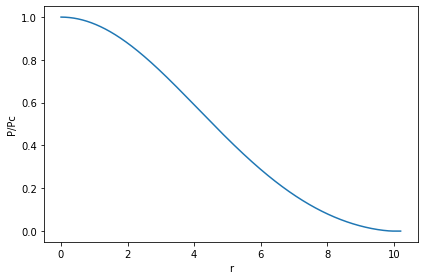

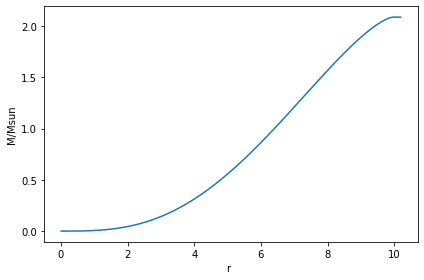

In [8]:
plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

In [9]:
# Load Data
df = pd.read_csv("sly.csv")

## Repeat for many different IVP
mStar_list = []
mR_list = []
ec_list = []

for i in tqdm(range(1,30), disable = False):
    # Load EOS
    e, p = df_to_ep(df)
    EOS = get_ep(e, p)

    # Initial Conditions
    km2cm = 1e5
    r_i = 1e-8
    p_c = p[-i]
    
    # Skip boundary case of highest pressure
    if p_c >= p.max():
        continue
    
    e_c = EOS(p_c)
    m0 = e_c * 4/3 * np.pi * r_i**3
    init_VEC = [p_c, m0]
    msun = 2e33
    p_min = min(p)

    # Integrate
    p, m, r_arr = tov(EOS, init_VEC, r_i, p_min)
    r_arr = r_arr/km2cm
    m = m/msun

    mStar = m.max()
    mR = r_arr.max()
    
    mStar_list.append(mStar)
    mR_list.append(mR)
    ec_list.append(e_c)

100%|██████████| 29/29 [00:06<00:00,  4.68it/s]


Maximum mass of this EOS is 2.04Msun with a radius of 10.03km
Maximum central energy density is 12.307
Minimum central energy density is 1.110


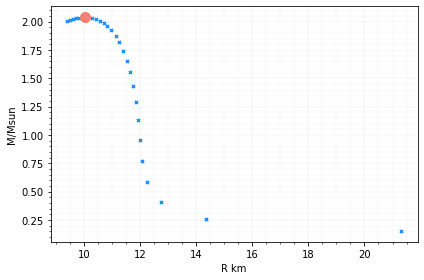

In [10]:
mStar_arr = np.array(mStar_list)
mR_arr = np.array(mR_list)
ec_arr = np.array(ec_list)

m_max = mStar_arr.max()
max_idx = np.argmax(mStar_arr)
r_max = mR_arr[max_idx]
ec_max = ec_arr[max_idx]

print(f"Maximum mass of this EOS is {m_max:.2f}Msun\
 with a radius of {r_max:.2f}km")

print(f"Maximum central energy density is {ec_max/(n_den*c**2):.3f}")
print(f"Minimum central energy density is {ec_arr.min()/(n_den*c**2):.3f}")

plt.scatter(mR_arr, mStar_arr, s=10, 
            marker = "x", color = "dodgerblue")
plt.scatter(r_max, m_max, s = 100, color = "salmon")
plt.xlabel("R km")
plt.ylabel("M/Msun")
utkarshGrid()
plt.show()

In [11]:
EOS_df_list = ["sly.csv", "sly230a.csv", "mpa1.csv", "hqc18.csv"]
colors = plt.cm.viridis(np.linspace(0,1,len(EOS_df_list)))

 25%|██▌       | 1/4 [00:05<00:15,  5.07s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
100%|██████████| 4/4 [00:55<00:00, 13.86s/it]


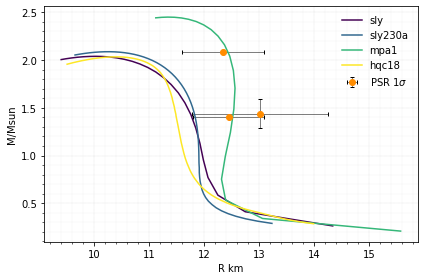

In [15]:
# Load Data
plt.figure()
for j in tqdm(range(len(EOS_df_list))):
    path = EOS_df_list[j]
    df = pd.read_csv(path)

    ## Repeat for many different IVP
    mStar_list = []
    mR_list = []

    for i in tqdm(range(1,len(df)), disable = True):
        # Load EOS
        e, p = df_to_ep(df)
        EOS = get_ep(e, p)

        # Initial Conditions
        km2cm = 1e5
        r_i = 1e-8
        p_c = p[-i]

        # Skip boundary case of highest pressure
        if p_c >= p.max():
            continue

        e_c = EOS(p_c)
        m0 = e_c * 4/3 * np.pi * r_i**3
        init_VEC = [p_c, m0]
        msun = 2e33
        p_min = min(p)

        # Integrate
        p, m, r_arr = tov(EOS, init_VEC, r_i, p_min)
        r_arr = r_arr/km2cm
        m = m/msun

        mStar = m.max()
        mR = r_arr.max()

        mStar_list.append(mStar)
        mR_list.append(mR)
        
        # If starr is less than % of Msun, exit inner loop
        if mStar < 0.3: 
            break

    mStar_arr = np.array(mStar_list)
    mR_arr = np.array(mR_list)

    plt.plot(mR_arr, mStar_arr, label = f"{path[:-4]}", 
             color = colors[j])

# Plotting error bars on pulsars
psr_r_list = [12.45, 12.35, 13.02]
psr_r_err_list = [0.65, 0.75, 1.24]
psr_m_list = [1.4, 2.08, 1.44] # No errors given on mass
psr_m_err_list = [0.01, 0.01, 0.15]
plt.errorbar(psr_r_list, psr_m_list, 
             xerr=psr_r_err_list, 
             yerr=psr_m_err_list,
             elinewidth=0.5,
             capsize=2,
             ecolor='black',
             fmt='o',
             label=r"PSR 1$\sigma$",
             color="darkorange",
             )

# Labeling
plt.xlabel("R km")
plt.ylabel("M/Msun")
utkarshGrid()
plt.legend()
plt.show()